# Nested sampling for multiple spectra of the same object

Forward modeling of multiple spectra for the same object using modern atmospheric models and the ``DYNESTY`` Bayesian framework.

In [2]:
import seda # import the seda package
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
from astropy.io import fits, ascii
from dynesty import plotting as dyplot # to plot nested sampling results


    SEDA package imported


Read the observed spectra of interest.

As an example here, let's read the near-infrared IRTF/SpeX and the mid-infrared Spitzer/IRS spectra for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract) and [Suárez & Metchev (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract), respectively.

Read SpeX spectrum:

In [9]:
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read IRS spectrum:

In [10]:
IRS = ascii.read('data/0415-0935_IRS_spectrum.dat')
wl_IRS = IRS['wl(um)'] # in um
flux_IRS = IRS['flux(Jy)'] # in Jy
eflux_IRS = IRS['eflux(Jy)'] # in Jy

# convert IRS fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.convert_flux(wl=wl_IRS, flux=flux_IRS, eflux=eflux_IRS, 
                                     unit_in='Jy', unit_out='erg/s/cm2/A')
flux_IRS = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_IRS = out_convert_flux['eflux_out'] # in erg/s/cm2/A

Plot SED to check everything looks okay:

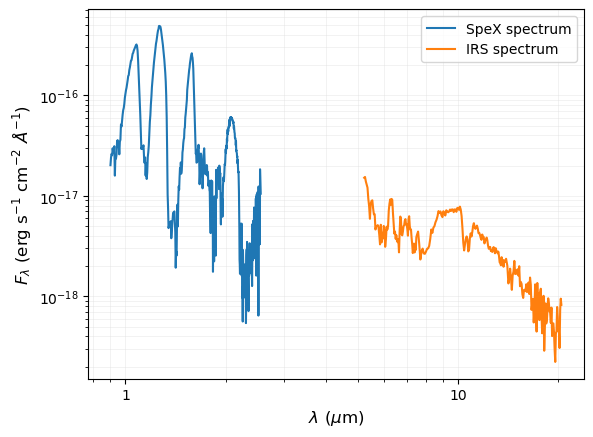

In [4]:
fig, ax = plt.subplots()

plt.plot(wl_SpeX, flux_SpeX, label='SpeX spectrum')
plt.plot(wl_IRS, flux_IRS, label='IRS spectrum')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend()

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

**Read input data**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.InputData).

For any SEDA function, we can also see the function description directly on the notebook with the command ``help()``, e.g.:

``help(seda.input_parameters.InputData)``


Define lists with the input spectra:

In [5]:
# wavelenghts
wl_spectra = [wl_SpeX, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'

# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 100]
# reference wavelength at which the resolution is given
lam_res = [2.0, 10.0] # um

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.InputData(wl_spectra=wl_spectra, flux_spectra=flux_spectra, 
                         eflux_spectra=eflux_spectra, flux_unit=flux_unit, res=res, 
                         lam_res=lam_res, distance=distance, edistance=edistance)


   Input data loaded successfully


Download (if not yet) the atmospheric models you want to use. 

See the available atmospheric models with the command below and read more about them [here](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models). 

Also consider [this tutorial](https://seda.readthedocs.io/en/latest/notebooks/tutorial_models_examination.html) to explore the free parameters in the models and their coverage.

In [6]:
# available atmospheric models
seda.available_models()

{'Sonora_Diamondback': 'Morley et al (2024)',
 'Sonora_Elf_Owl': 'Mukherjee et al. (2024)',
 'LB23': 'Lacy & Burrows (2023)',
 'Sonora_Cholla': 'Karalidi et al. (2021)',
 'Sonora_Bobcat': 'Marley et al. (2021)',
 'ATMO2020': 'Phillips et al. (2020)',
 'BT-Settl': 'Allard et al. (2012)',
 'SM08': 'Saumon & Marley (2008)'}

**Read model grid options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.ModelOptions).

In [7]:
# select the atmospheric models of interest
model = 'Sonora_Elf_Owl'
# path to the directory or directories containing the model spectra
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_700.0_800.0/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_850.0_950.0/',
            ]
# set parameter ranges to select a grid subset and to be used as uniform priors
# when a free parameter range is not specified, the whole grid range will be explored
Teff_range = np.array((700, 900)) # Teff range
logg_range = np.array((4.0, 5.0)) # logg range
R_range = np.array((0.6, 1.0)) # Rjup

# load model options
my_model = seda.ModelOptions(model=model, model_dir=model_dir, logg_range=logg_range, 
                             Teff_range=Teff_range, R_range=R_range)


   Model options loaded successfully


**Tip:** If you plan to model several spectra from the same instrument (same resolution), you can save the convolved model spectra to reuse them and do subsequent fits much faster. For this, set the parameter ``path_save_spectra_conv`` in ``seda.ModelOptions`` above to a folder path where you want to store the convolved spectra. Once the spectra are stored, the next time you run the code just replace ``model_dir`` by the path you used in ``path_save_spectra_conv`` and set ``skip_convolution=True`` to avoid the model convolution. This was implemented thanks to [issue](https://github.com/suarezgenaro/seda/issues/14).

**Read Bayes fit options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.BayesOptions).

Consider the default full wavelength range of each input spectrum for the fits. Otherwise, we can use the parameter ``fit_wl_range`` to set different fit ranges. 

In [8]:
# choose a filename (optional) to save the sampling results as a pickle file
# it is convenient to set a non-default name when running 
# the code several times in the same folder to avoid overwriting results
bayes_pickle_file = f'{model}_bayesian_sampling_multiple_spectra.pickle'

my_bayes = seda.BayesOptions(my_data=my_data, my_model=my_model,
                             bayes_pickle_file=bayes_pickle_file)


For input observed spectrum #0

      3000 model spectra selected with:
         Teff=[700, 900]
         logg=[4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/3000 [00:00<?, ?it/s]

      elapsed time: 5.6 min

For input observed spectrum #1

      3000 model spectra selected with:
         Teff=[700, 900]
         logg=[4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/3000 [00:00<?, ?it/s]

      elapsed time: 7.6 min

   Bayes fit options loaded successfully


**Run nested sampling**

In [9]:
out_bayes = seda.bayes(my_bayes)


   Estimate Bayesian posteriors

      Uniform priors:
         Teff range = [700 900]
         logg range = [4. 5.]
         logKzz range = [2. 9.]
         Z range = [-1.  1.]
         CtoO range = [0.5 2.5]
         R range = [0.6 1. ]


   Starting dynesty...


28677it [10:30, 45.46it/s, batch: 4 | bound: 42 | nc: 1 | ncall: 263715 | eff(%): 10.612 | loglstar: 16056.496 < 16063.509 < 16061.902 | logz: 16024.589 +/-  0.209 | stop:  0.931]         

      Bayesian sampling results saved successfully

   Bayesian sampling ran successfully
      elapsed time: 10.5 min


**Plot results**

The ``out_bayes`` output above from ``seda.bayes()`` is the input file to make plots.

If ``out_bayes`` is not in memory (if we reloaded the notebook or restarted the kernel), we need to open the pickle file first as below.

In [3]:
# open pickle file
bayes_pickle_file = 'Sonora_Elf_Owl_bayesian_sampling_multiple_spectra.pickle'
with open(bayes_pickle_file, 'rb') as file:
    # deserialize and retrieve the variable from the file
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


Make corner plot using dynesty tools:

Quantiles:
Teff (K) [(0.025, 749.9742629977571), (0.5, 749.9987594085013), (0.975, 750.0161640786215)]
Quantiles:
logg [(0.025, 4.370161373615644), (0.5, 4.381228436745002), (0.975, 4.392061321426143)]
Quantiles:
logKzz [(0.025, 3.9939471967326368), (0.5, 3.9992604560419496), (0.975, 4.001362605554855)]
Quantiles:
Z [(0.025, 0.0781493438561472), (0.5, 0.0828729089465181), (0.975, 0.08761614342078503)]
Quantiles:
C/O [(0.025, 1.0068131047346212), (0.5, 1.016615633784664), (0.975, 1.026394559766829)]
Quantiles:
R (Rj) [(0.025, 0.8212877174008555), (0.5, 0.8218606763562881), (0.975, 0.8224413036833796)]


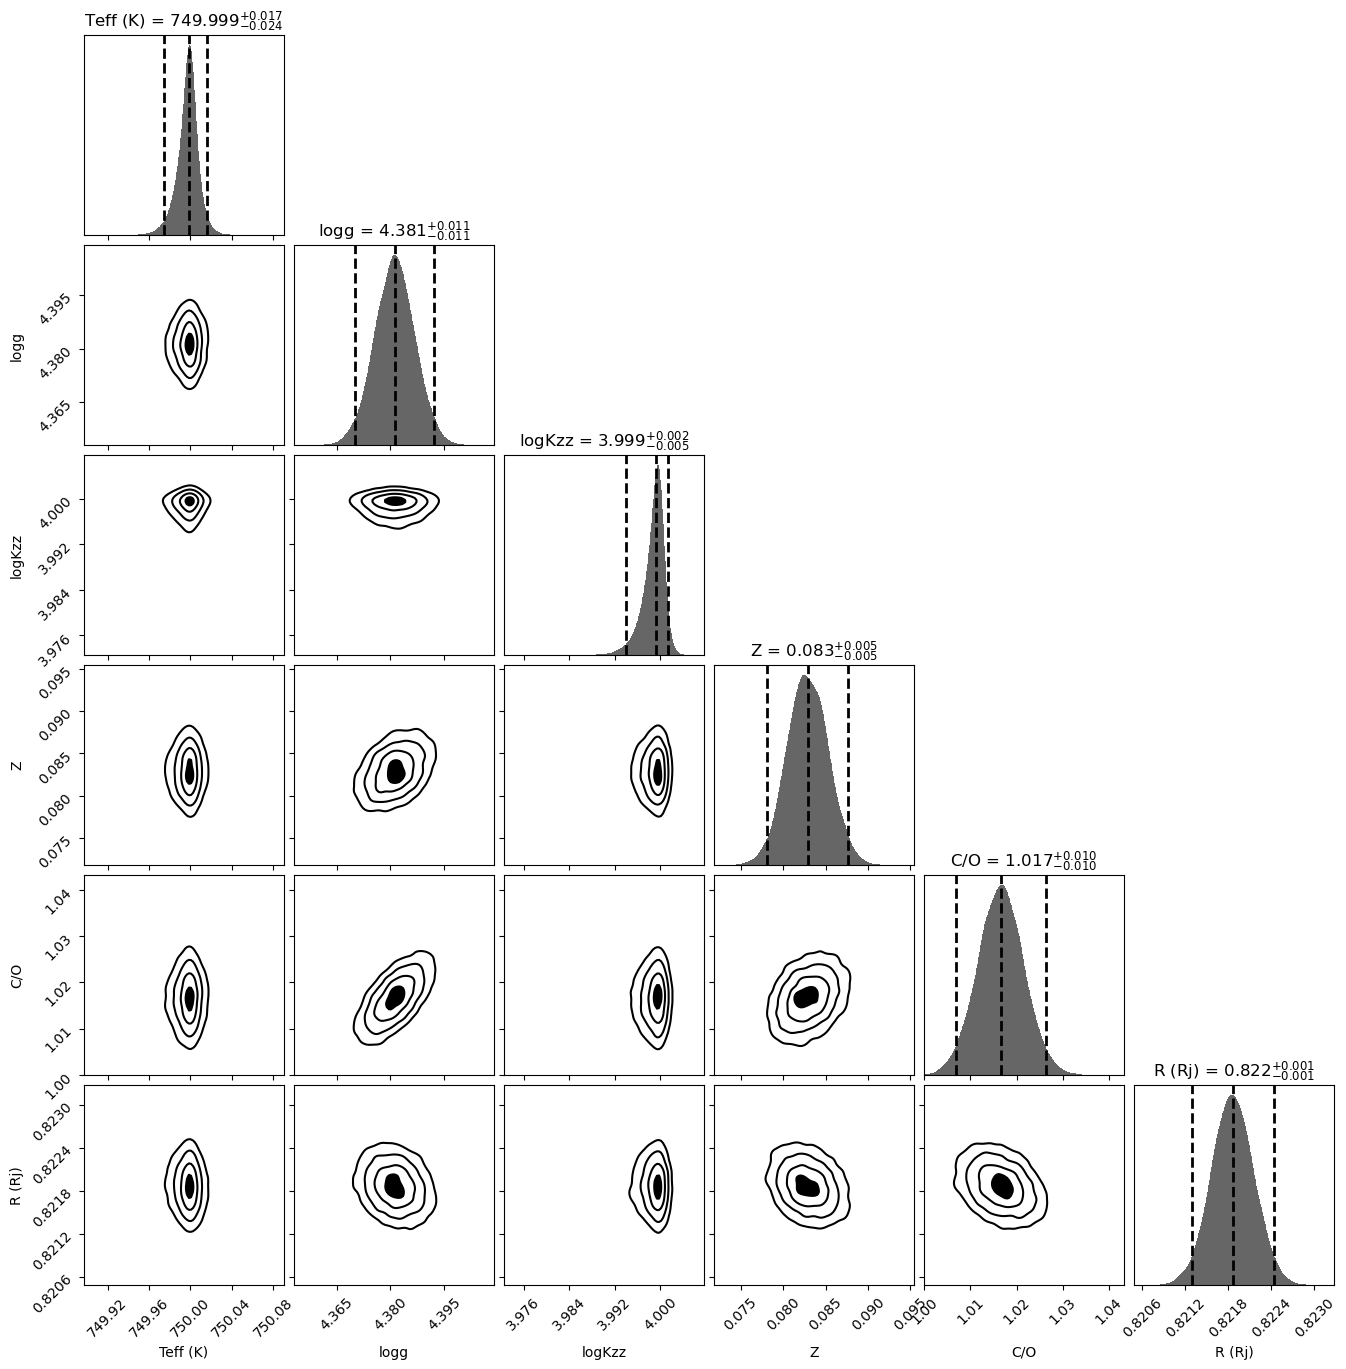

In [4]:
# plot the 2-D marginalized posteriors.
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(out_bayes['out_dynesty'], show_titles=True, verbose='true', 
                              title_fmt='.3f', title_kwargs={'y': 1.0}, labels=labels)

Plot a summary of the run

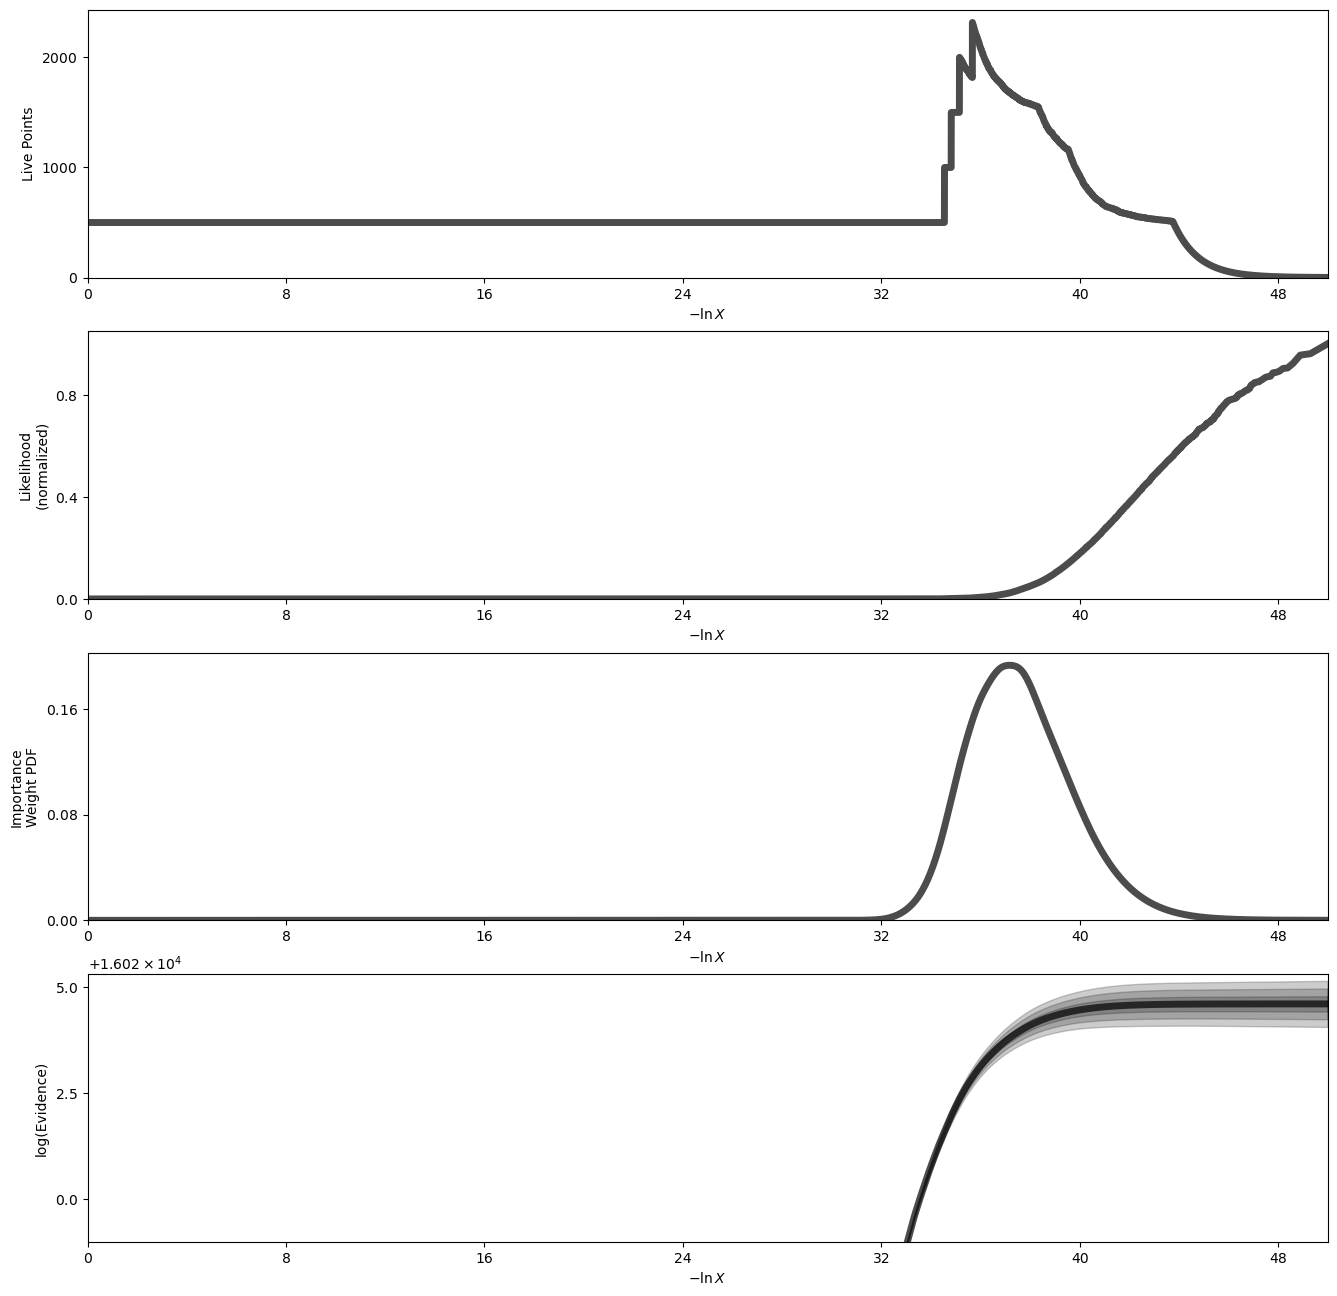

In [5]:
fig, axes = dyplot.runplot(out_bayes['out_dynesty'], color='black', mark_final_live=False, logplot=True)

Plot traces and 1-D marginalized posteriors

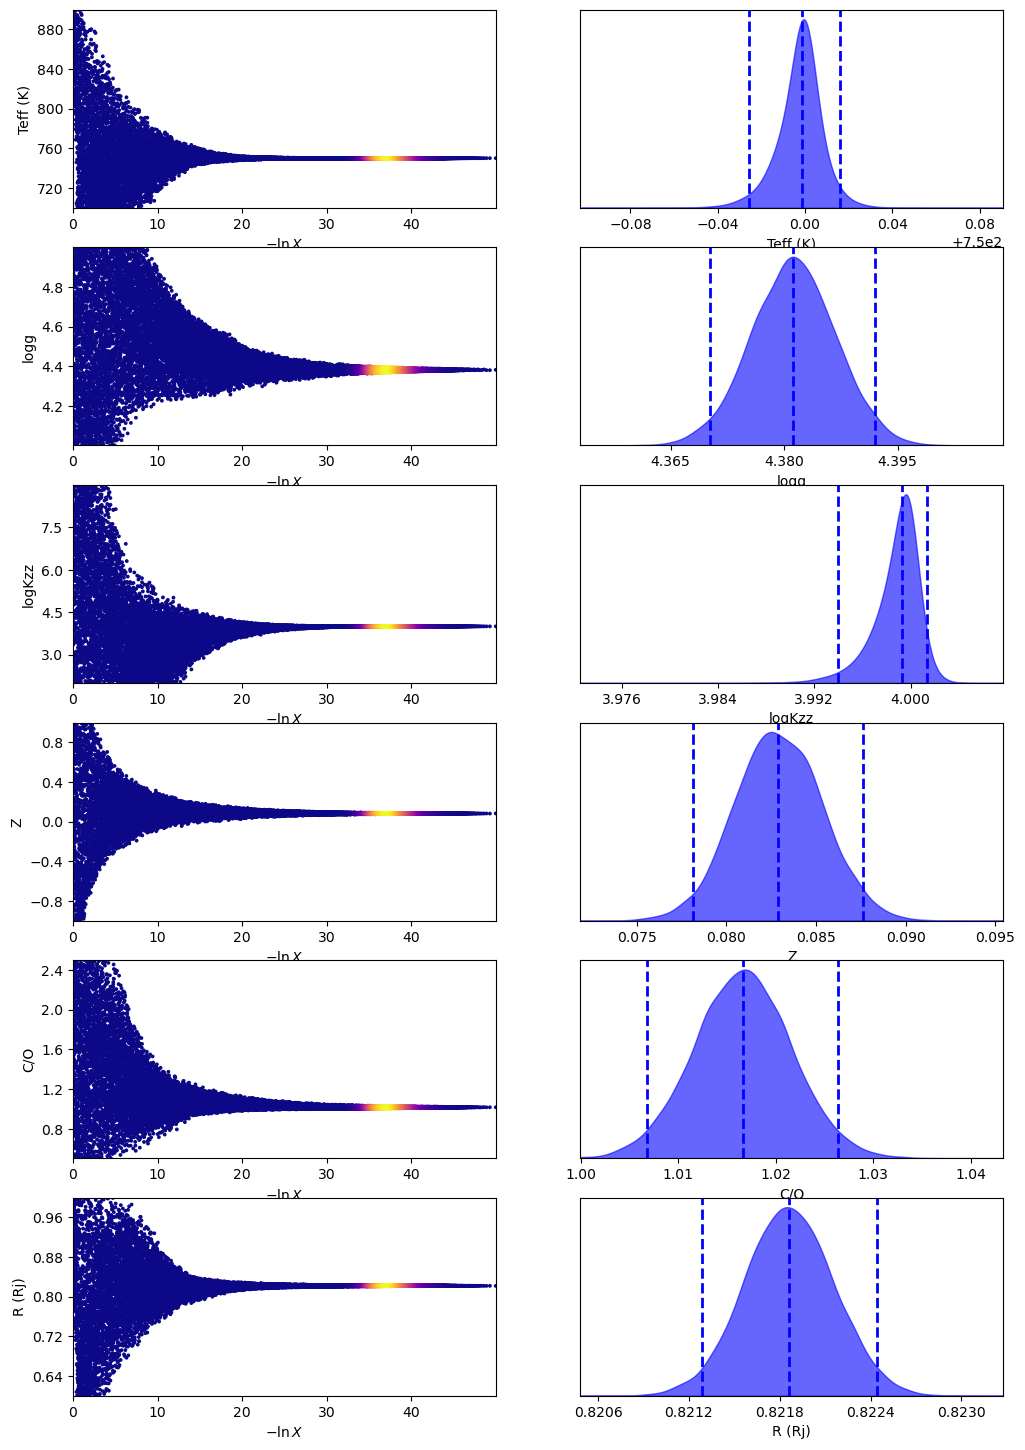

In [6]:
fig, axes = dyplot.traceplot(out_bayes['out_dynesty'], labels=labels)

**Plot the model spectrum from median posteriors**

SED with the best model fit from the Bayesian sampling.

The pickle file generated by ``seda.bayes_fit`` and stored with the name ``my_bayes.bayes_pickle_file`` is the input file to make plots. We can provide the name by either using ``my_bayes.bayes_pickle_file`` (if ``my_bayes`` is in memory) or just typing it.

The best model fit will be generated by interpolating into a model grid subset around the median posteriors.

*Note that the Elf Owl models do not cover wavelenghts longer than 15 microns.*


      32 model spectra selected with:
         Teff=[700.0, 750.0]
         logg=[4.25, 4.5]
         Z=[0.0, 0.5]
         logKzz=[2.0, 4.0]
         CtoO=[1.0, 1.5]


Reading model grid:   0%|          | 0/32 [00:00<?, ?it/s]

      elapsed time: 0.0 s


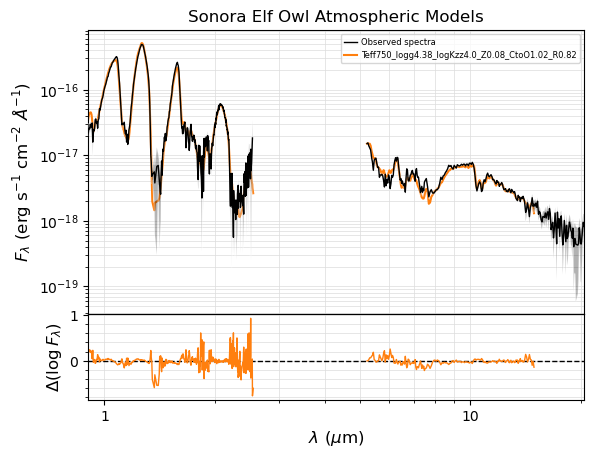

In [7]:
# using default logarithmic scale for fluxes
seda.plot_bayes_fit(bayes_pickle_file, xlog=True)

Zoom in on the SpeX spectrum:


      32 model spectra selected with:
         Teff=[700.0, 750.0]
         logg=[4.25, 4.5]
         Z=[0.0, 0.5]
         logKzz=[2.0, 4.0]
         CtoO=[1.0, 1.5]


Reading model grid:   0%|          | 0/32 [00:00<?, ?it/s]

      elapsed time: 1.0 s


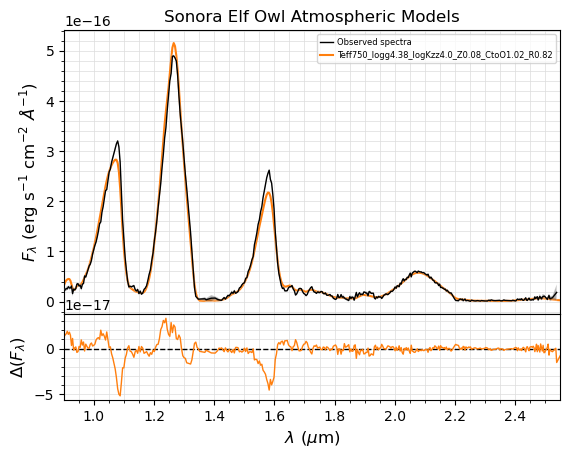

In [13]:
# plot fluxes in linear scale
seda.plot_bayes_fit(bayes_pickle_file, ylog=False,
                    xrange=[wl_SpeX.min(), wl_SpeX.max()])

Zoom in on the IRS spectrum:


      32 model spectra selected with:
         Teff=[700.0, 750.0]
         logg=[4.25, 4.5]
         Z=[0.0, 0.5]
         logKzz=[2.0, 4.0]
         CtoO=[1.0, 1.5]


Reading model grid:   0%|          | 0/32 [00:00<?, ?it/s]

      elapsed time: 1.0 s


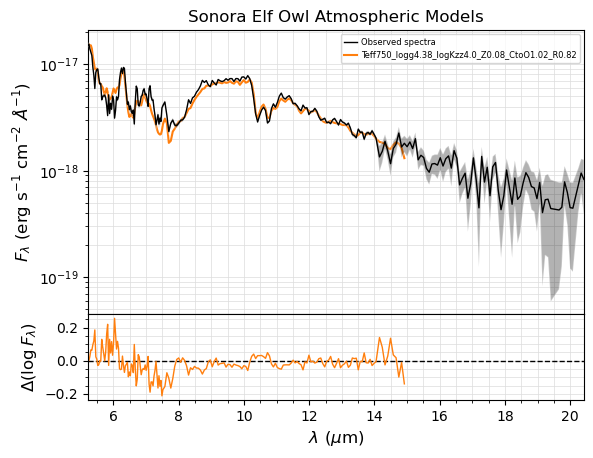

In [15]:
# plot fluxes in log scale
seda.plot_bayes_fit(bayes_pickle_file, 
                    xrange=[wl_IRS.min(), wl_IRS.max()])